# Imports

In [188]:
import pickle
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, matplotlib
from umap import UMAP
import sklearn
import hypercluster as hc
sns.set(style = 'white', color_codes=True, font_scale = 1.3)
matplotlib.rcParams.update({'savefig.bbox': 'tight', 'savefig.dpi': '500'})

### Input data and filtering

In [2]:
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0).transpose()

In [3]:
data.shape

(526, 500)

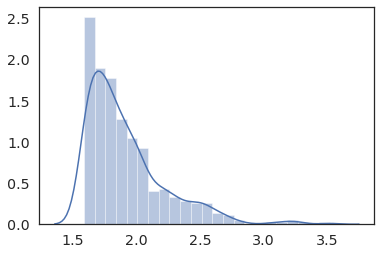

In [4]:
sns.distplot(data.std())

In [5]:
data = hc.visualize.zscore(data.transpose()).transpose()

# Running with default hyperparameters

In [183]:
clusterer = hc.MultiAutoClusterer().fit(data).evaluate(evaluation_methods=hc.constants.inherent_metrics)

# Visualize evaluations

##### Across all clusterers

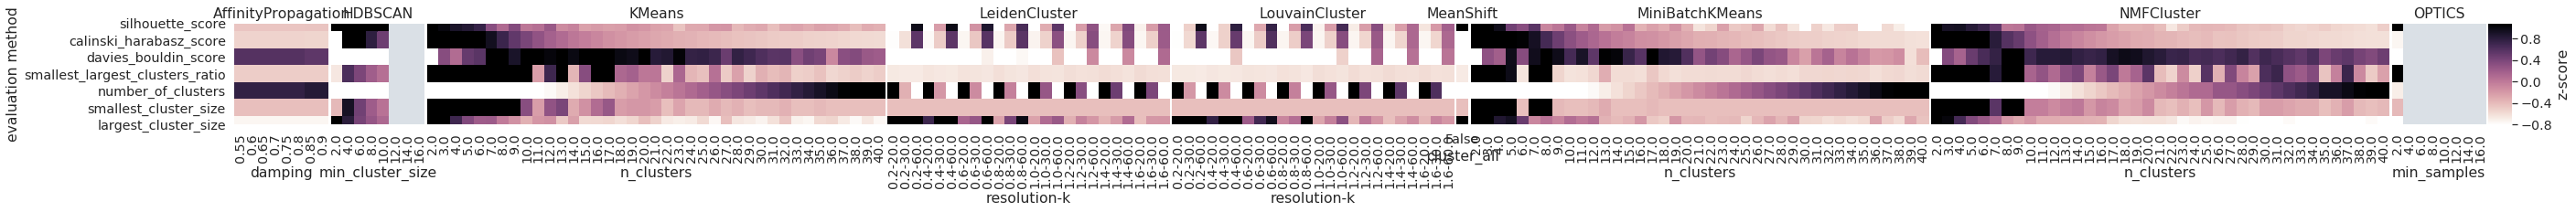

In [21]:
axs = clusterer.visualize_evaluations(savefig=True, output_prefix='figures/heatmap.brca-rna.evaluations')

#Can modify axs before saving. 
# axs[3].set_xlabel('cluster_all', va='top')


##### Make it easier to visualize how two parameters affect results

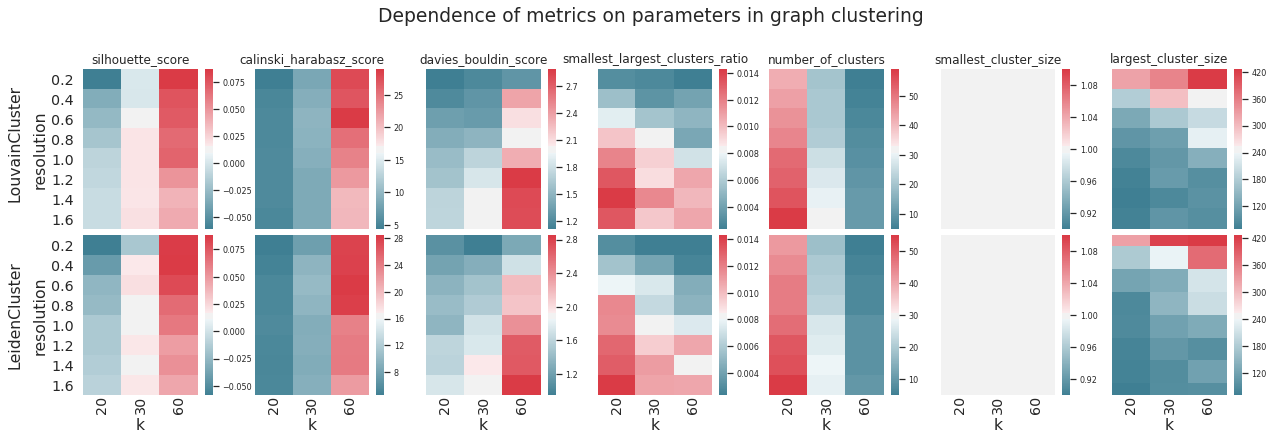

In [76]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap.set_bad('#BDBDBD')
cmap.set_over('#9E031A')
cmap.set_under('#0C4A60')

fig, axs = plt.subplots(
    ncols = len(hc.constants.inherent_metrics), 
    nrows=2,
    figsize=(3*len(hc.constants.inherent_metrics), 6),
    gridspec_kw=dict(hspace=0.04, wspace=0.2),
    sharey=True, sharex=True
)

for row, method in enumerate(['LouvainCluster', 'LeidenCluster']):
    df = clusterer.evaluation_[method].transpose()
    for col, metric in enumerate(df.columns):
        ax = axs[row, col]
        visdf = df[metric].unstack()
        sns.heatmap(visdf, xticklabels=visdf.columns,yticklabels=visdf.index, cmap=cmap, ax=ax)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)
        if col > 0:
            ax.set_ylabel('')
        if row == 0:
            ax.set_xlabel('')
            ax.set_title(metric, fontsize=12)
        ax.set_yticklabels(visdf.index, rotation=0)
        ax.set_xticklabels([int(i) for i in visdf.columns], rotation=90, va='center')
axs[0,0].text(-2, 6.5, 'LouvainCluster', rotation=90)
axs[1,0].text(-2, 6.5, 'LeidenCluster', rotation=90)
fig.suptitle('Dependence of metrics on parameters in graph clustering', va='bottom')
plt.savefig('figures/heatmaps.graphs-clusterers.metrics.pdf')

##### Making scree plots for each metric

ERROR:root:Cannot convert MeanShift data to floats, skipping visualization
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
ERROR:root:Cannot convert MeanShift data to floats, skipping visualization
ERROR:root:Cannot convert MeanShift data to floats, skipping visualization
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: overf

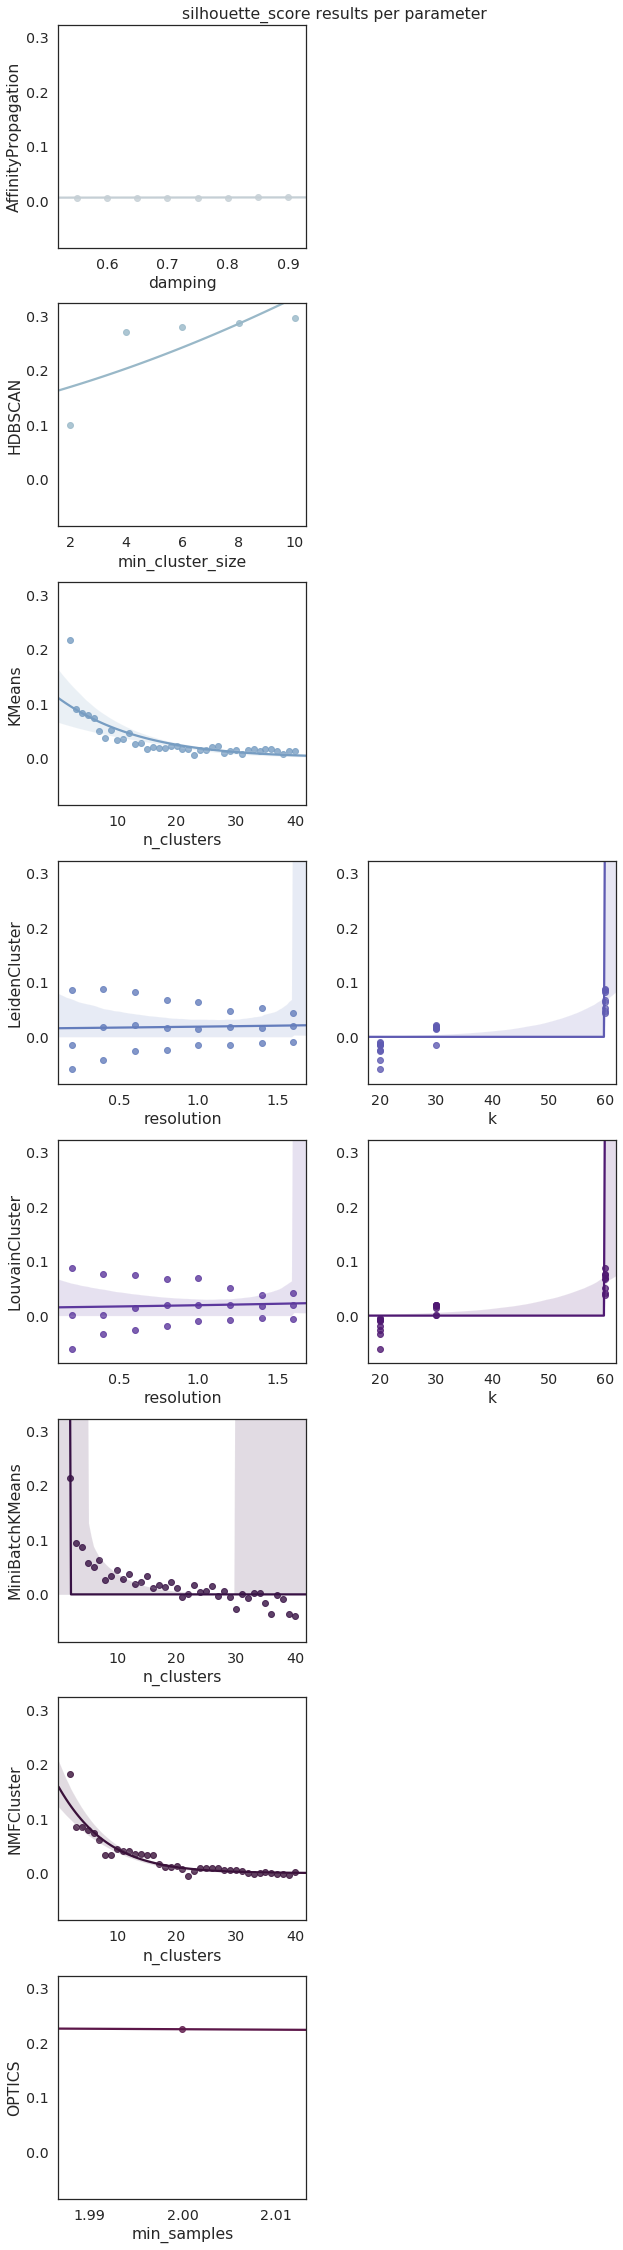

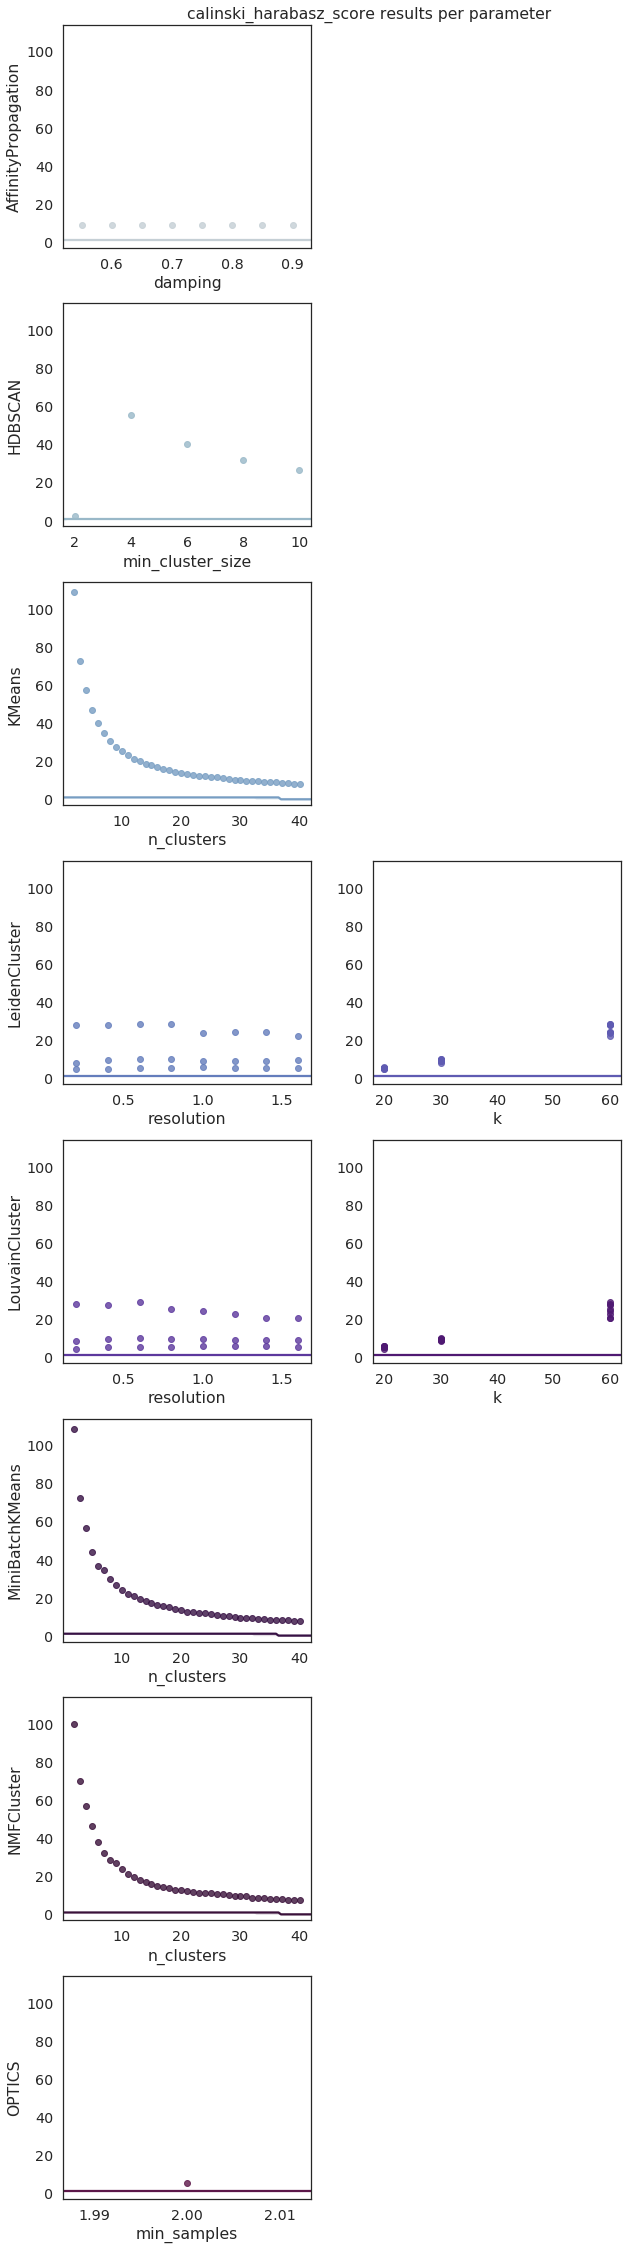

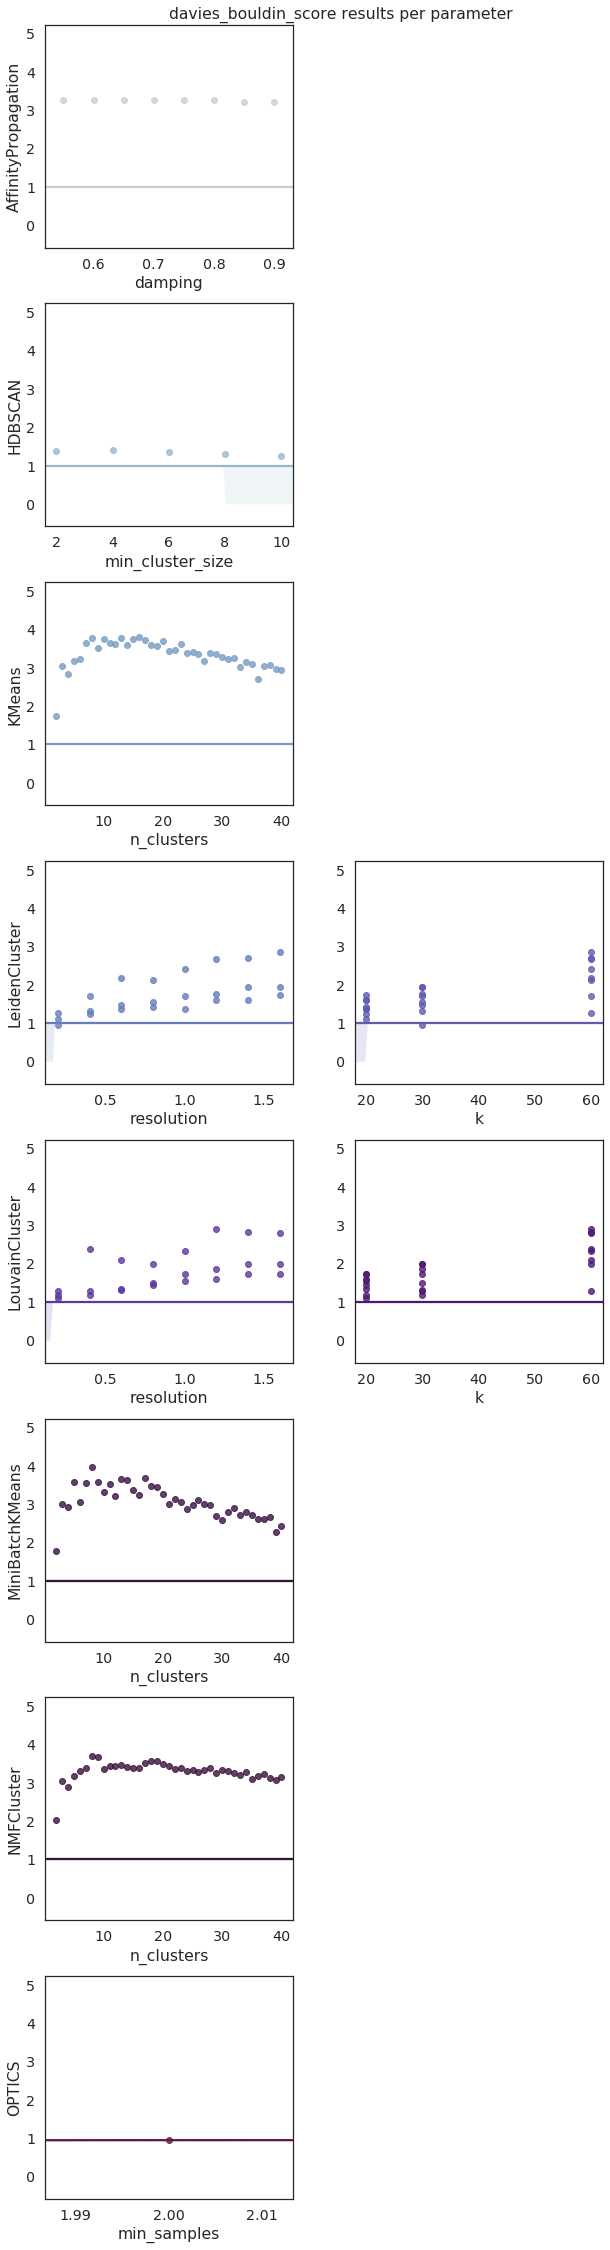

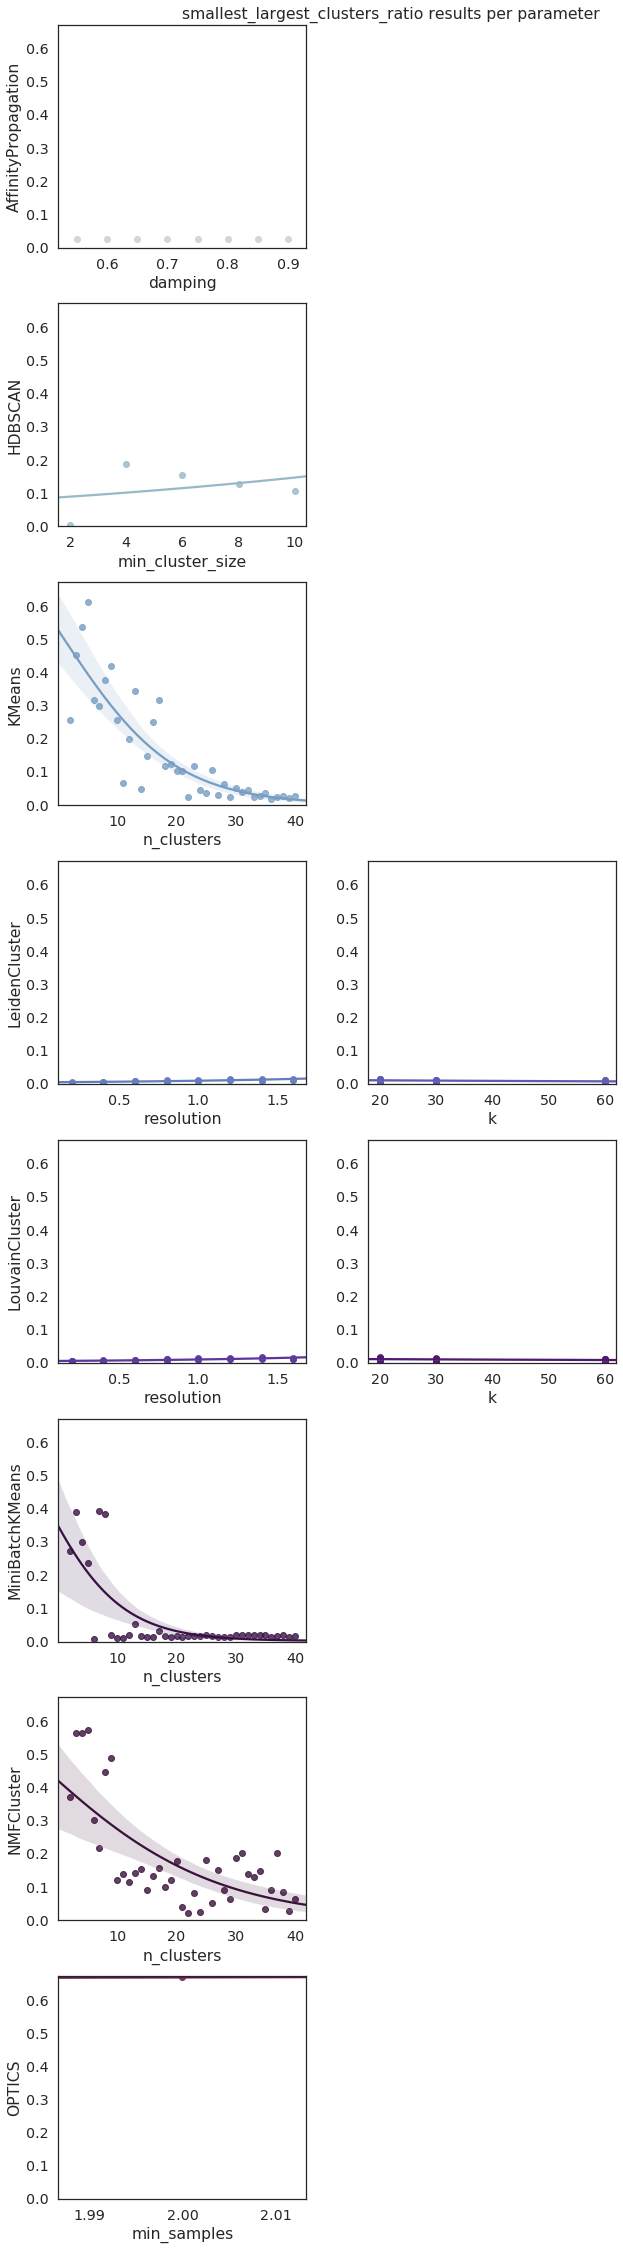

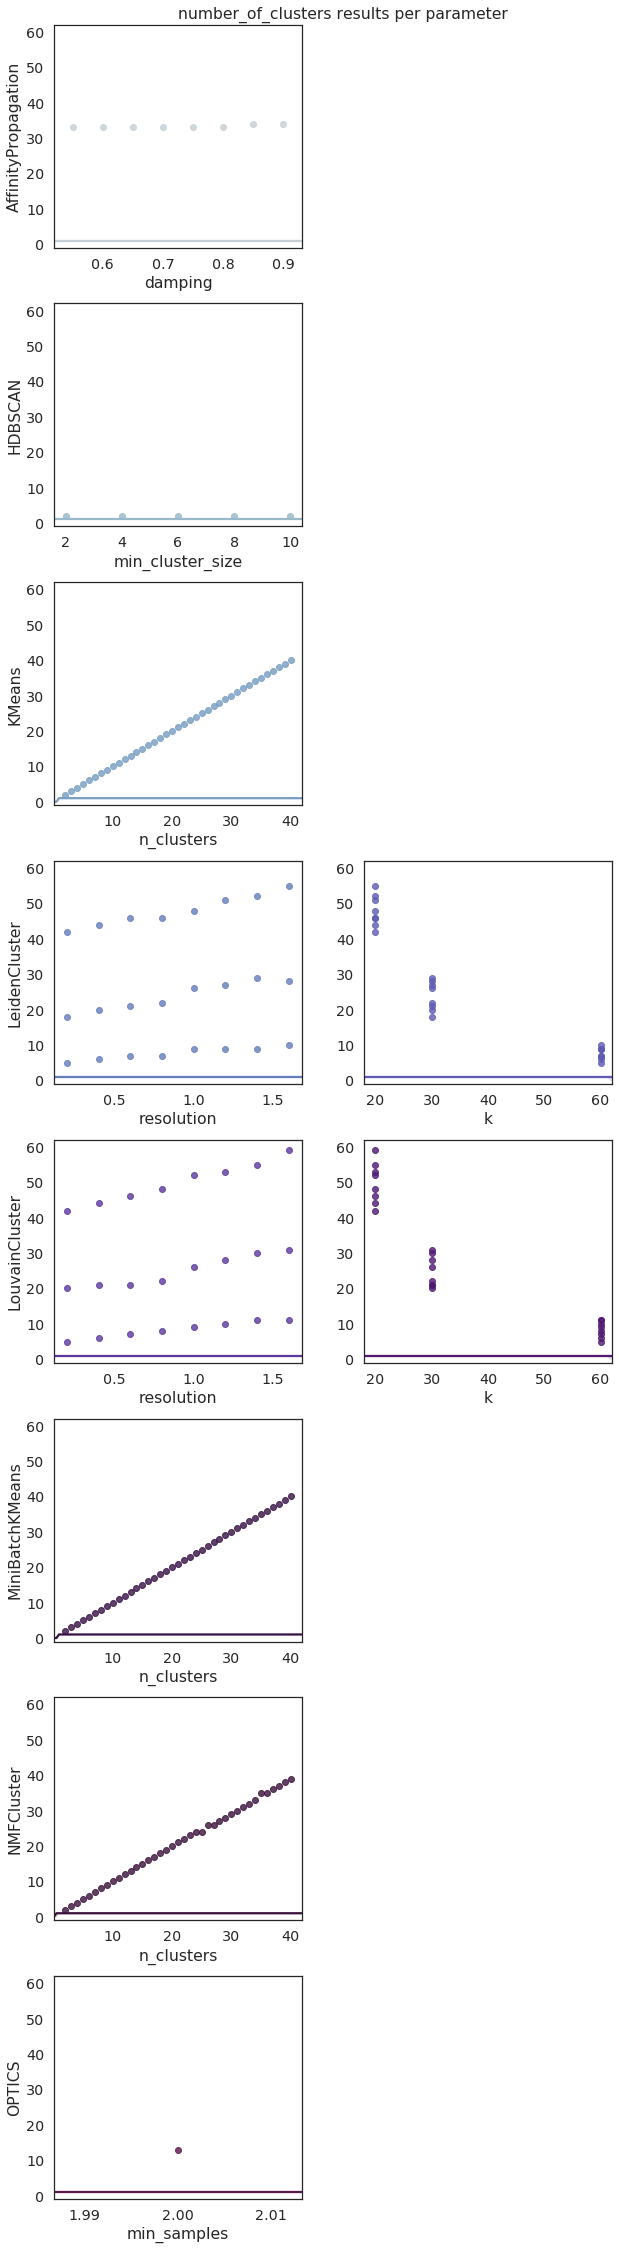

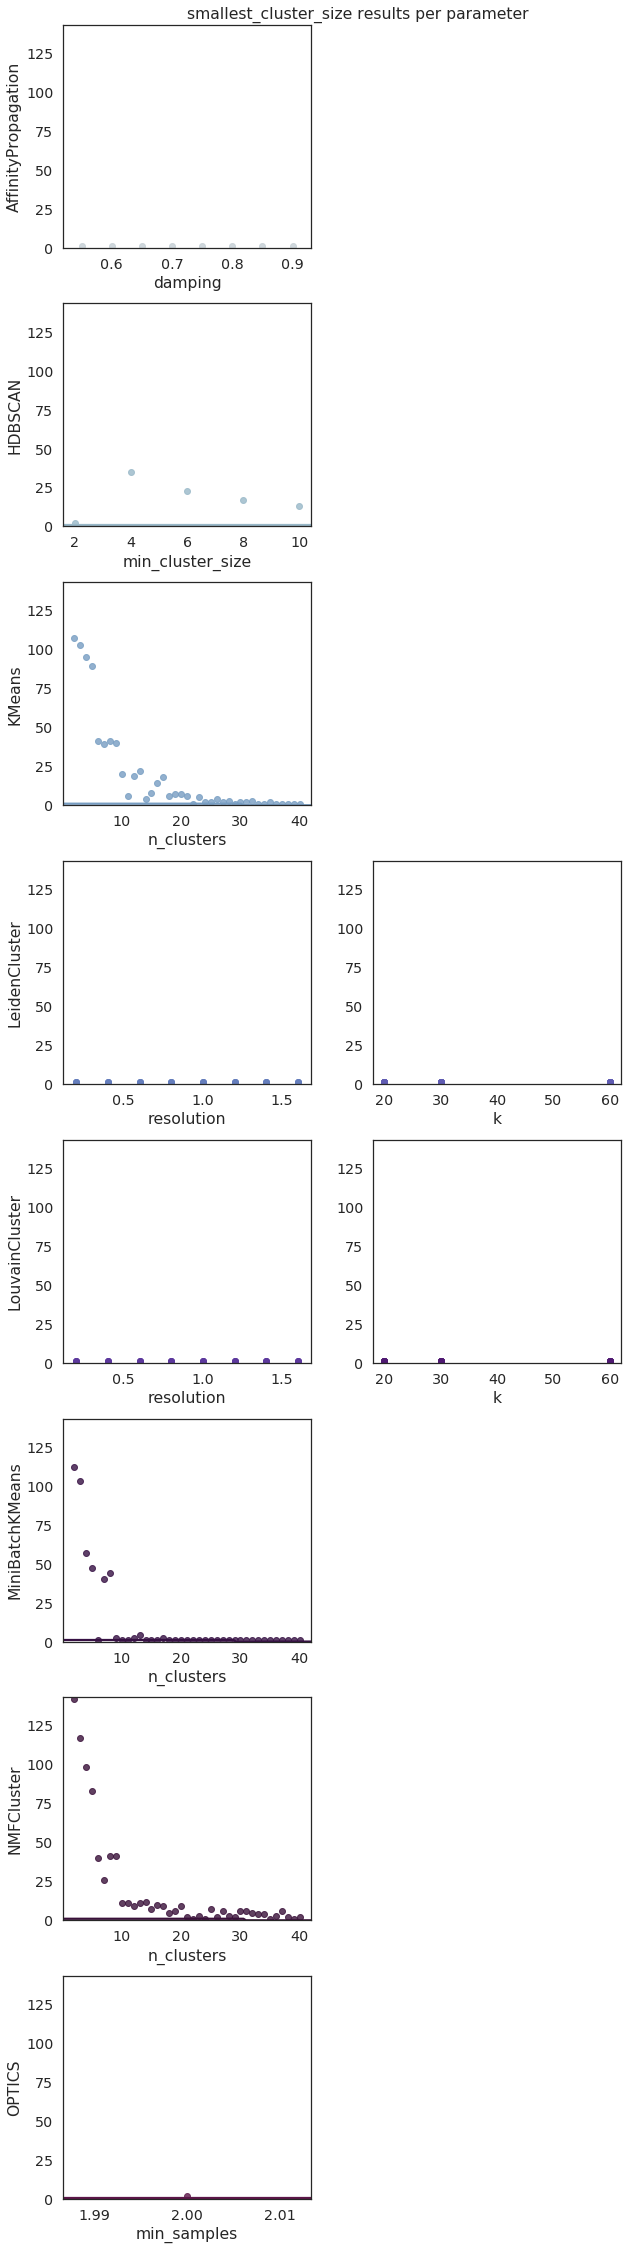

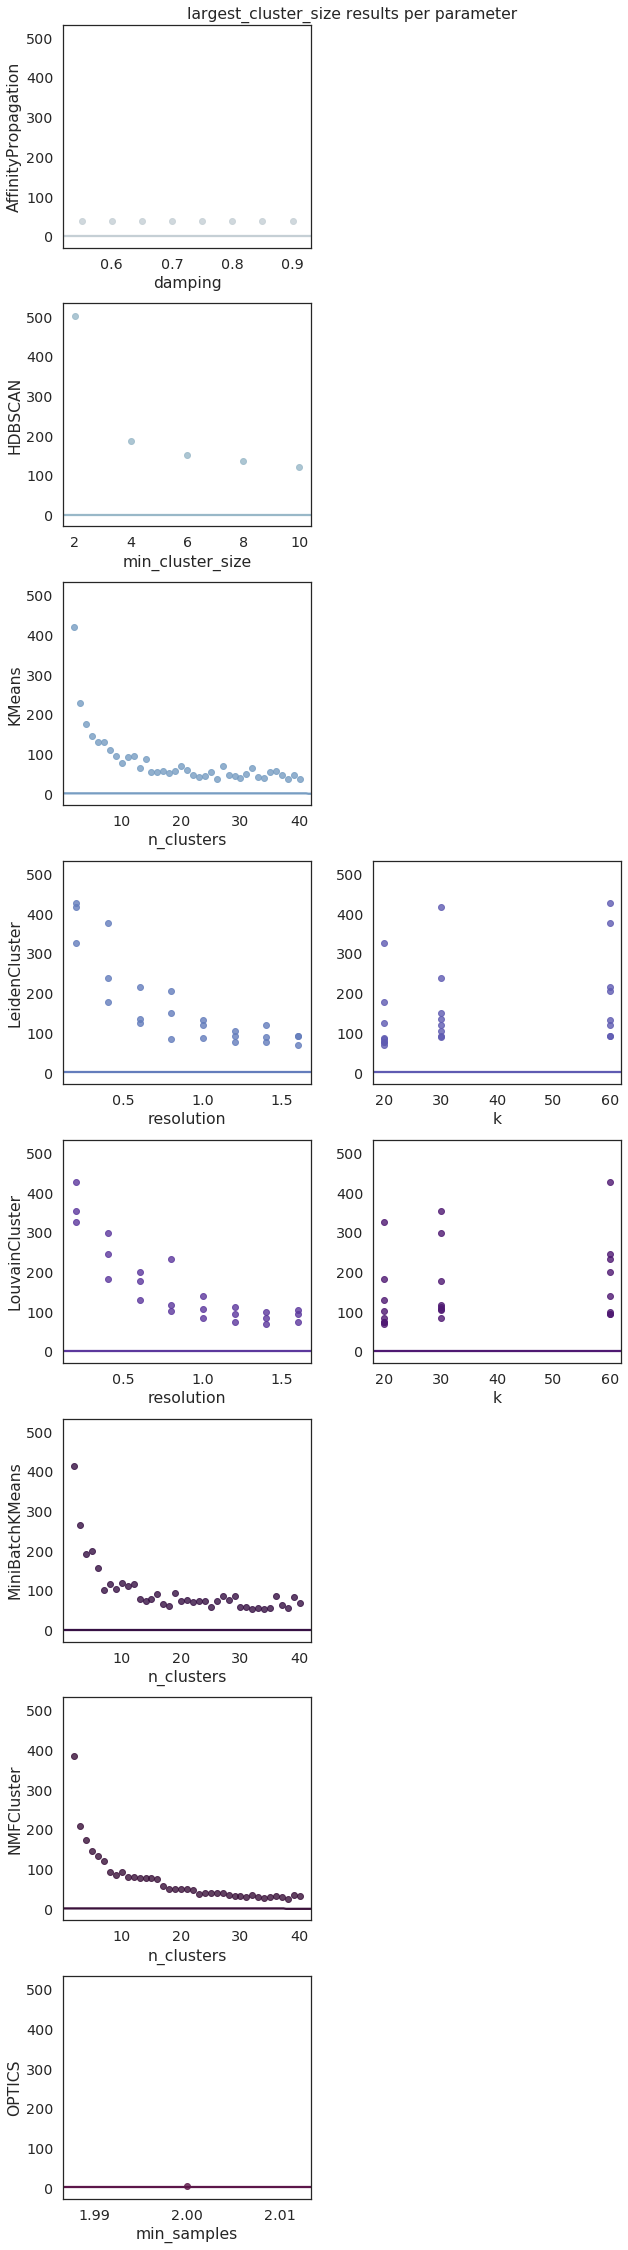

In [50]:
for metric in hc.constants.inherent_metrics:
    clusterer.visualize_for_picking_labels(metric, savefig_prefix='figures/scatter.%s' % metric)

# Compare all results that have 4 clusters to PAM50 subtyping

In [159]:
annotations = pd.read_csv('data_clinical_sample.txt', sep='\t', index_col=0, skiprows=4)
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0).transpose()
# filtering down to visualize
data = data.loc[:, data.std()>np.percentile(data.std(), 75)]

In [160]:
conditions_with_4_clusterers = clusterer.evaluation_df.columns[clusterer.evaluation_df.loc['number_of_clusters']==4]
labels = hc.utilities.pick_best_labels(clusterer.evaluation_df[conditions_with_4_clusterers], clusterer.labels_df[conditions_with_4_clusterers], 'smallest_largest_clusters_ratio', 'max')

In [161]:
annotations = pd.concat([labels, annotations[['PAM50_SUBTYPE']]], join='inner', axis=1).sort_values(['NMFCluster;n_clusters-4', 'PAM50_SUBTYPE'])

In [162]:
colors = {
    'Luminal A': '#3A53A5',
    'CLDN-low':'#EFC032',
    'HER2-enriched':'#B9539F',
    'Basal-like':'#EE2025',
    'Normal':'gray',
    'Luminal B':'#6ECDDE',
    'nan':'#FFFFFF',
    'Normal-like':'#BDBDBD',
    0: '#6ECDDE',
    1: '#EE2025',
    2: '#3A53A5',
    3: '#B9539F'
}

col_colors = annotations.replace(colors)

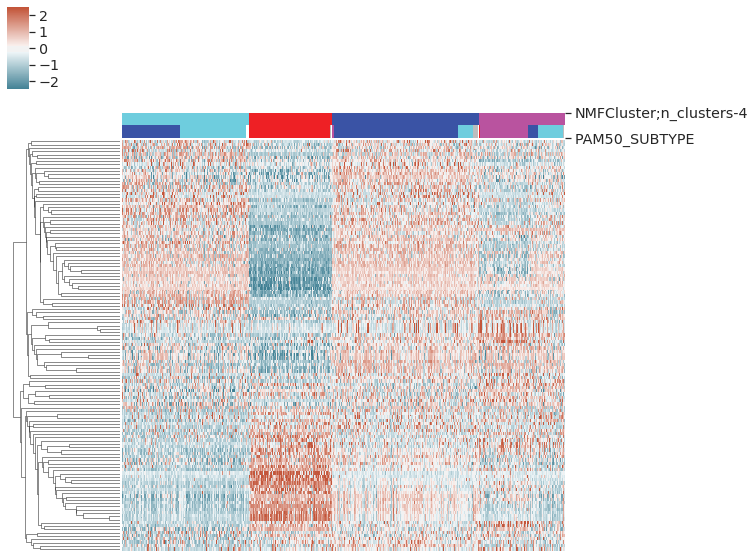

In [175]:
cg = sns.clustermap(
    hc.visualize.zscore(data.transpose().reindex(annotations.index, axis=1)), 
    col_cluster=False,
    xticklabels=False, 
    yticklabels=False, 
    col_colors=col_colors, 
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True), 
    vmin=-2.5, vmax=2.5
)
cg.ax_heatmap.set_ylabel('')
cg.savefig('figures/clustermap.nmf4-vs-psm50.pdf')

In [173]:
clusterer.evaluate(hc.constants.inherent_metrics+hc.constants.need_ground_truth, gold_standard=annotations.dropna(how='any')['PAM50_SUBTYPE'])

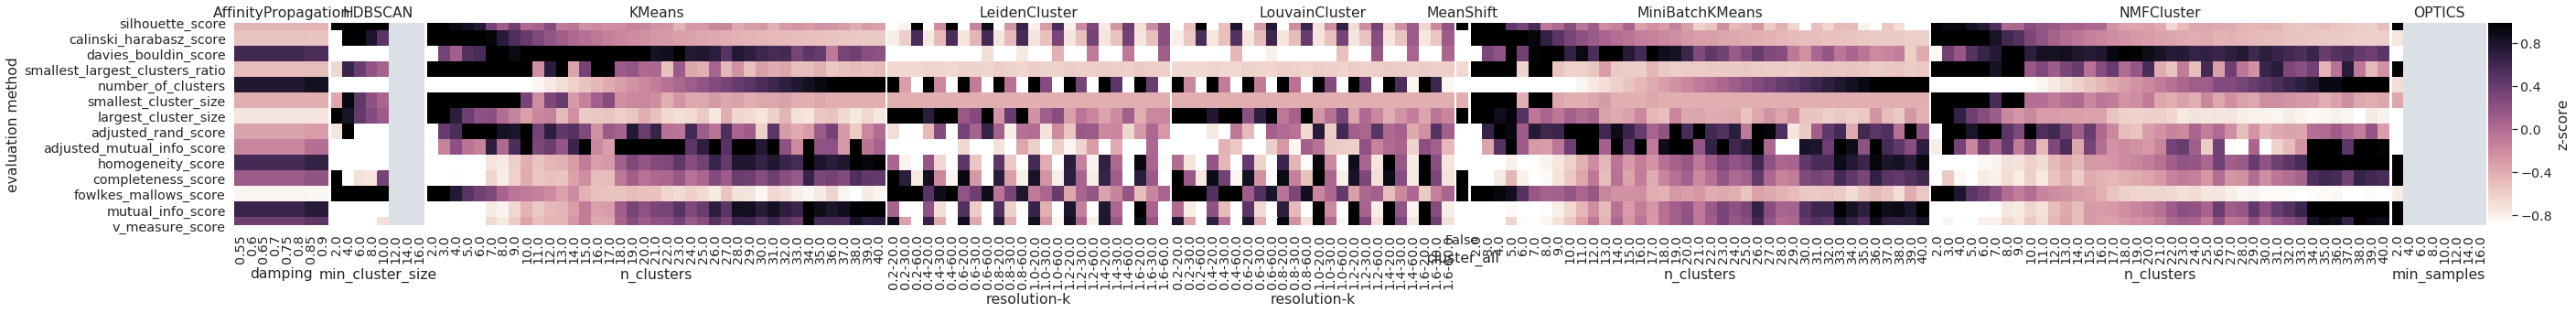

In [174]:
axs = clusterer.visualize_evaluations(savefig=True, output_prefix='figures/heatmap.brca-rna.evaluations.PAM50_comp')

In [172]:
for metric in hc.constants.need_ground_truth:
    print(
        metric, 
        hc.utilities.evaluate_one(
                annotations.dropna(how='any')['NMFCluster;n_clusters-4'], 
                metric, 
                gold_standard=annotations.dropna(how='any')['PAM50_SUBTYPE']
        )
    )

adjusted_rand_score 0.45275025130906915
adjusted_mutual_info_score 0.5443359514541736
homogeneity_score 0.5543568421499789
completeness_score 0.5427109379515125
fowlkes_mallows_score 0.6080789333660002
mutual_info_score 0.7359088332378102
v_measure_score 0.5484720766026344


# Visualize clusters with dimensionality reduction

In [179]:
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0)
data = hc.visualize.zscore(data).transpose()

In [214]:
method = 'LouvainCluster'

umap = UMAP(n_components=2).fit_transform(data)
umap = pd.DataFrame(umap, index=data.index, columns=['UMAP1', 'UMAP2'])

params = clusterer.labels_[method].transpose().index
ks = sorted(list(set(params.get_level_values(1))))
ress = sorted(list(set(params.get_level_values(0))))

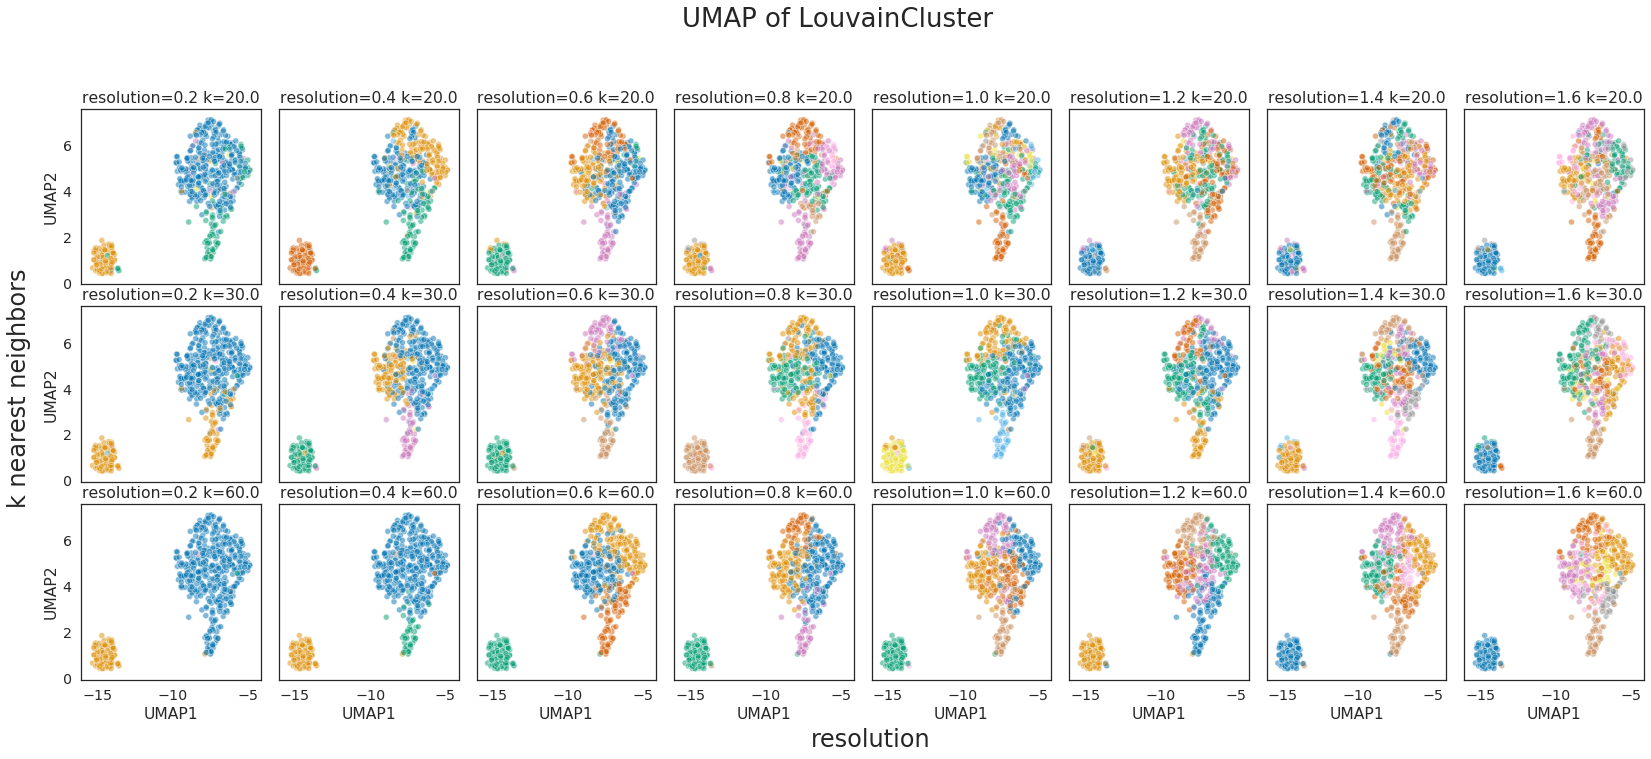

In [220]:
fig, axs = plt.subplots(
    figsize=(3.5*len(ress), 3.5*len(ks)),
    nrows=len(ks),
    ncols=len(ress),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.125, wspace=0.1)
)
for row, k in enumerate(ks):
    for col, resolution in enumerate(ress):
        ax = axs[row, col]
        temp = clusterer.labels_[method][[(resolution, k)]]
        temp.columns = ['%s;%s-%s;%s-%s' % (method,'resolution', resolution, 'k', k)]
        temp.loc[:, temp.columns[0]] = temp[temp.columns[0]].astype(str)
        temp = pd.concat([temp, umap], axis=1)
        
        sns.scatterplot(
            x='UMAP1',
            y='UMAP2',
            hue=temp.columns[0],
            palette=sns.color_palette('colorblind', n_colors=len(temp[temp.columns[0]].unique())),
            data=temp,
            ax=ax,
            legend=False,
            alpha=0.5
        )
        ax.set_title('%s=%s %s=%s' % ('resolution', resolution, 'k', k))
axs[1, 0].text(-21, -1, 'k nearest neighbors', fontsize=24, rotation=90)
axs[2, 3].text(-7, -3, 'resolution', fontsize=24)
fig.suptitle('UMAP of %s' % method, fontsize=26, va='bottom')
plt.savefig('figures/grid.scatter.louvain-umaps.pdf')